Everything on CPU

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# from utils import *

In [6]:
tf.__version__

'2.15.0'

In [7]:
tf.random.set_seed(2024)

In [8]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [9]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [10]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [11]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [12]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [13]:
# alternative to keras' TimeSeriesGenerator
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [14]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


### SIMPLE LSTM

In [15]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
# plot_model(model=model_enc_dec, show_shapes=True)

In [16]:
plot_model(model=model_enc_dec, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50



32/32 [==============================] - 4s 11ms/step - loss: 0.1343
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0334
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0160
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 6/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0065
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 8/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0048
Epoch 9/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0041
Epoch 10/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0038
Epoch 11/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 12/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0033
Epoch 13/50
32/32 [============================

In [18]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [19]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [20]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [21]:
yhat_inverse = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [22]:
yhat_inverse-y_test_inverse

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2017-01-02,3.283270,0.348647,1.425442,1.808033,-0.467420,0.019283,0.264525,-2.331902,0.036031,0.113642,...,-1.509493,0.357423,-1.696119,-0.632762,0.042832,0.202417,0.063894,0.757572,-0.917730,-0.030001
2017-01-03,2.067641,0.316379,0.933362,1.834322,-0.322035,0.000710,-0.197987,-1.370631,0.042553,0.016986,...,-0.832174,0.365239,-1.078712,-0.389309,0.024844,0.190662,0.026336,0.696433,-0.659800,-0.023647
2017-01-04,0.420504,0.302328,0.338264,1.140545,-0.310116,-0.038243,-0.680977,-0.791411,0.049223,-0.219614,...,0.891595,0.355173,-0.761127,-0.238902,-0.160445,0.146455,0.020408,0.465675,-0.548347,-0.037956
2017-01-05,0.065959,0.316537,-0.049344,0.876903,-0.072690,-0.060516,-0.657832,0.796656,0.073515,-0.363920,...,3.008856,0.378669,0.256126,-0.011328,-0.338042,0.191868,0.031262,0.347793,-0.587382,-0.055358
2017-01-06,0.859488,0.346772,-0.458815,0.568651,0.163068,-0.075103,-0.472590,1.163021,0.082967,-0.567113,...,2.899453,0.381428,1.034599,-0.032511,-0.355115,0.171664,0.086684,0.235766,-0.555912,-0.114748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,-28.283932,-0.820088,14.030418,8.177837,-2.149557,-0.181127,5.527408,-46.465299,-0.631655,1.263235,...,10.054903,0.324073,-7.761492,1.013139,-1.491549,2.192998,-1.824720,-1.482706,8.501431,2.894298
2017-12-22,-27.035412,-0.857613,14.618083,8.312894,-1.679365,-0.188307,5.527618,-45.387018,-0.644569,1.337257,...,10.432934,0.345547,-7.028552,2.235337,-1.465561,2.135794,-1.780348,-1.201662,8.493651,2.905144
2017-12-27,-26.280325,-0.885919,14.226670,8.098058,-1.835250,-0.210063,5.245421,-46.297932,-0.672082,1.151716,...,9.126363,0.345378,-7.082097,2.119094,-1.468565,1.981387,-1.787413,-0.896126,7.979225,2.775093
2017-12-28,-25.938484,-0.899967,14.189587,8.088291,-1.885123,-0.210235,5.189338,-45.963368,-0.663986,1.146878,...,8.624183,0.398106,-6.655279,2.430582,-1.383164,1.897571,-1.804050,-0.634109,7.869900,2.737413


In [23]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())

In [24]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.424536
mse: 59.12198
mape: 7.0115147


In [25]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

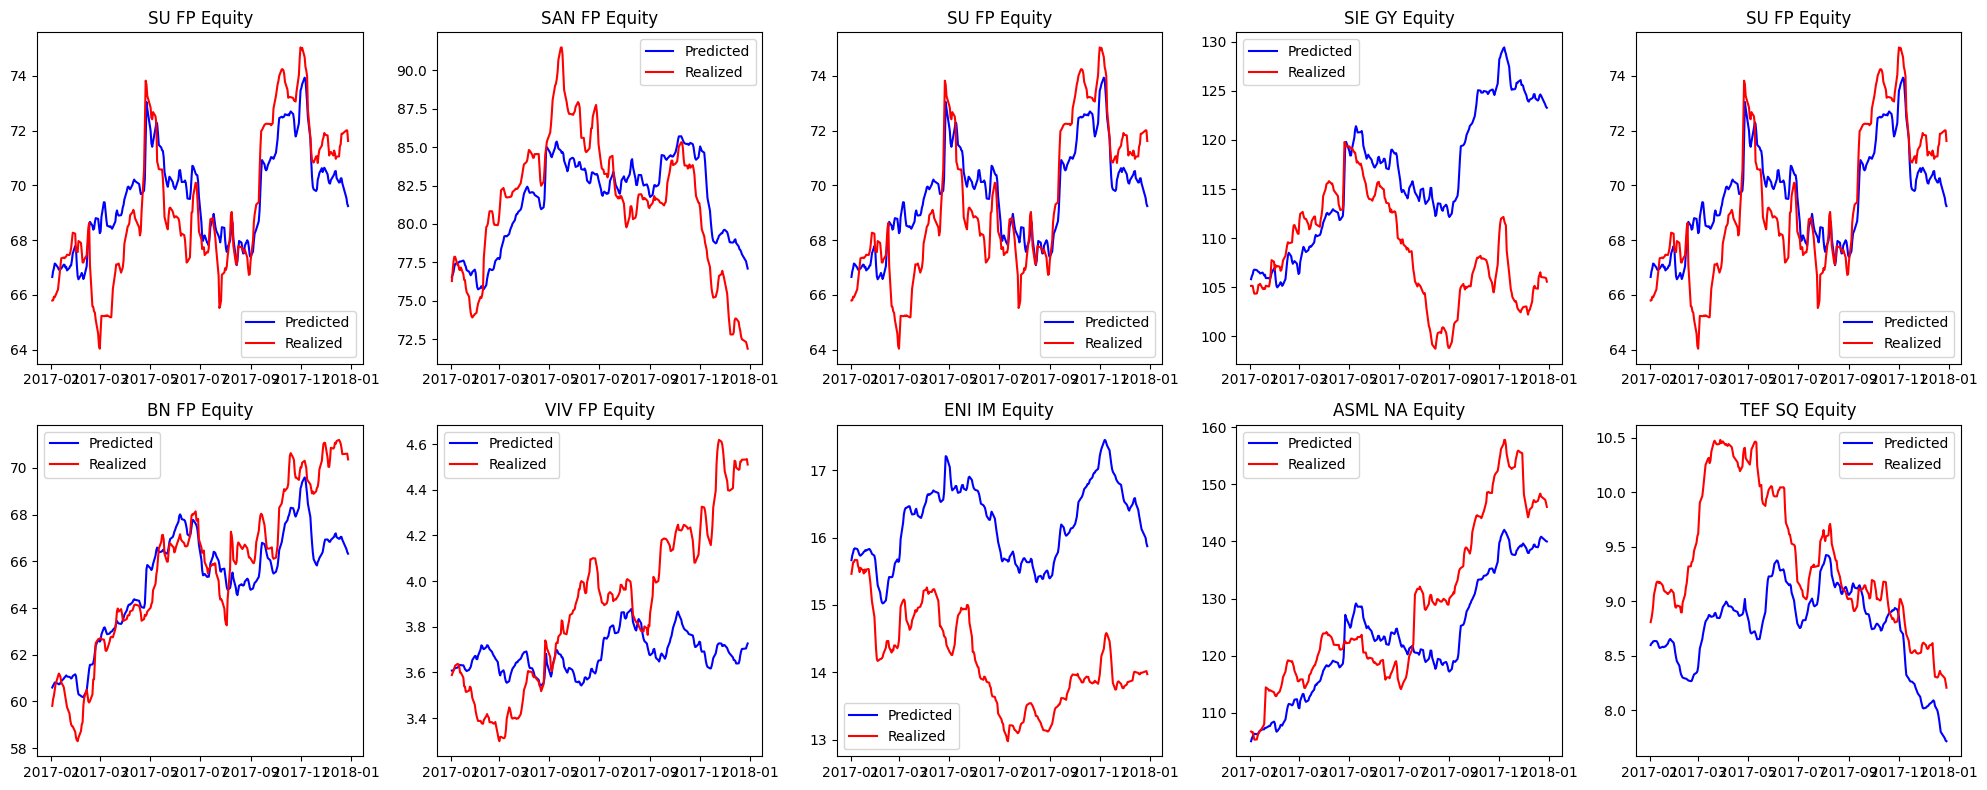

In [26]:
rand = np.random.randint(0, 41, 10)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(yhat_inverse.iloc[:, stock].name)

plt.tight_layout()
plt.show()

### CNN-LSTM

In [27]:
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

In [28]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 0.1080
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0261
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0072
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0063
Epoch 10/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 13/50
32/32 [==============================

In [29]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [30]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [31]:
yhat_inverse = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [32]:
yhat_inverse-y_test_inverse

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2017-01-02,2.602209,-0.049896,1.682293,1.940834,-0.471227,0.092138,1.894667,-4.123070,0.010236,0.341141,...,0.204435,0.434923,-3.410940,-1.050799,0.649865,-0.366477,-0.081257,1.467793,-0.465803,0.106148
2017-01-03,1.996107,-0.101827,1.260953,1.857062,-0.356209,0.084839,1.356388,-3.369960,0.008881,0.288960,...,0.585382,0.409558,-3.039451,-1.010151,0.655436,-0.460835,-0.119467,1.410142,-0.362803,0.086237
2017-01-04,0.838145,-0.134523,0.898162,1.176029,-0.304825,0.058270,0.863922,-2.324050,0.014127,0.145901,...,2.478051,0.376695,-2.619770,-0.851451,0.515802,-0.548029,-0.120214,1.187329,-0.172256,0.097855
2017-01-05,0.246425,-0.141817,0.419429,0.759128,-0.082431,0.031501,0.655950,-0.488378,0.030624,0.000465,...,4.625738,0.359359,-1.623689,-0.606352,0.350707,-0.540028,-0.116295,1.030088,-0.089022,0.064081
2017-01-06,0.667182,-0.131579,0.187105,0.566031,0.228978,0.019566,0.839048,0.854855,0.047098,-0.111243,...,5.245232,0.346378,-0.433403,-0.372103,0.398911,-0.535774,-0.078344,0.899148,0.391369,0.061841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,-31.734830,-4.011905,0.459442,5.768208,-1.480135,0.053827,8.622646,-47.161390,-0.749800,1.524677,...,7.849474,-0.263861,-26.443216,-2.126975,1.109466,1.244707,-3.913587,-1.399942,16.399373,3.080134
2017-12-22,-30.613049,-4.043802,1.179576,5.965749,-0.881800,0.051316,8.855125,-45.361933,-0.737985,1.708360,...,9.182156,-0.259404,-25.548984,-0.782645,1.149063,1.239763,-3.841385,-1.224901,16.914915,3.175926
2017-12-27,-29.655020,-4.062622,1.493272,6.161992,-0.768405,0.043929,9.075561,-44.361516,-0.726172,1.846103,...,9.765660,-0.264150,-24.661343,-0.303933,1.198668,1.199772,-3.804689,-1.047963,17.118202,3.231476
2017-12-28,-29.138573,-4.082661,1.428806,6.210063,-0.763442,0.044527,9.297492,-43.629521,-0.703840,1.939273,...,10.011726,-0.241613,-24.104383,-0.065794,1.220198,1.180538,-3.793545,-0.896160,17.073208,3.227552


In [33]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.252374
mse: 55.080196
mape: 7.813052


In [34]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

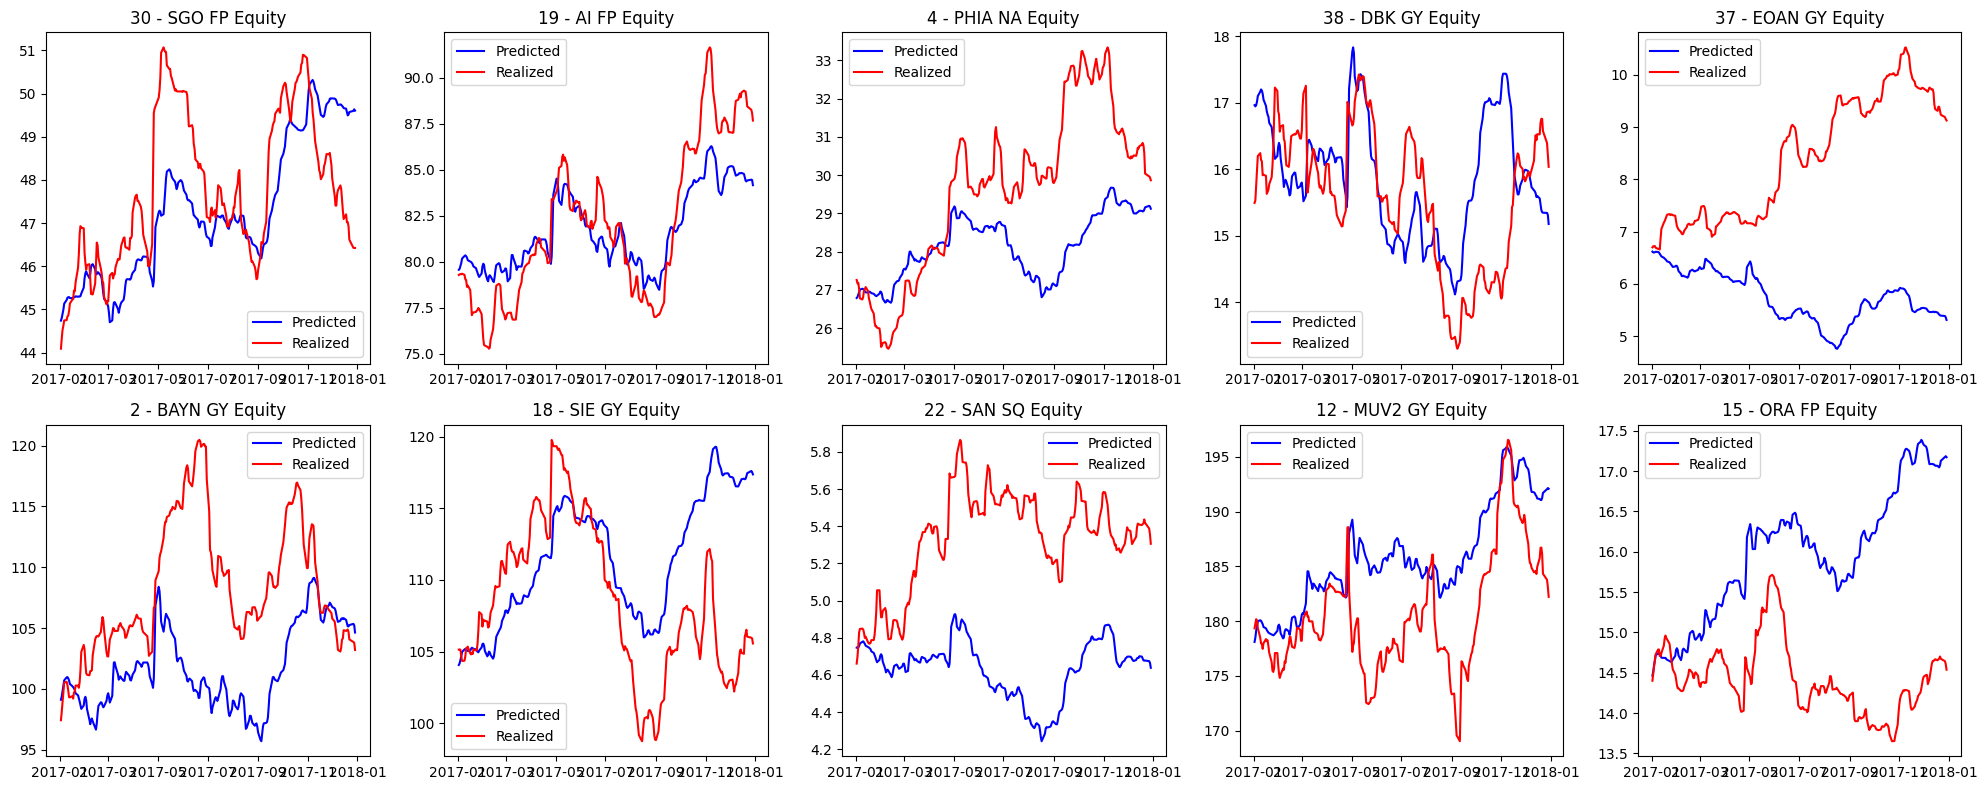

In [35]:
rand = np.random.choice(np.arange(41), size=10, replace=False)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(f'{stock} - {yhat_inverse.iloc[:, stock].name}')

plt.tight_layout()
plt.show()

### Multi-Head CNN-LSTM

In [36]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

In [37]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 21s 32ms/step - loss: 0.1746
Epoch 2/50
32/32 [==============================] - 1s 30ms/step - loss: 0.0571
Epoch 3/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0396
Epoch 4/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0285
Epoch 5/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0254
Epoch 6/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0226
Epoch 7/50
32/32 [==============================] - 1s 32ms/step - loss: 0.0215
Epoch 8/50
32/32 [==============================] - 1s 33ms/step - loss: 0.0204
Epoch 9/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0186
Epoch 10/50
32/32 [==============================] - 1s 37ms/step - loss: 0.0172
Epoch 11/50
32/32 [==============================] - 1s 34ms/step - loss: 0.0169
Epoch 12/50
32/32 [==============================] - 1s 39ms/step - loss: 0.0168
Epoch 13/50
32/32 [=================

In [38]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [39]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [40]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.395177
mse: 55.26929
mape: 7.8048663


In [41]:
yhat_inverse = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

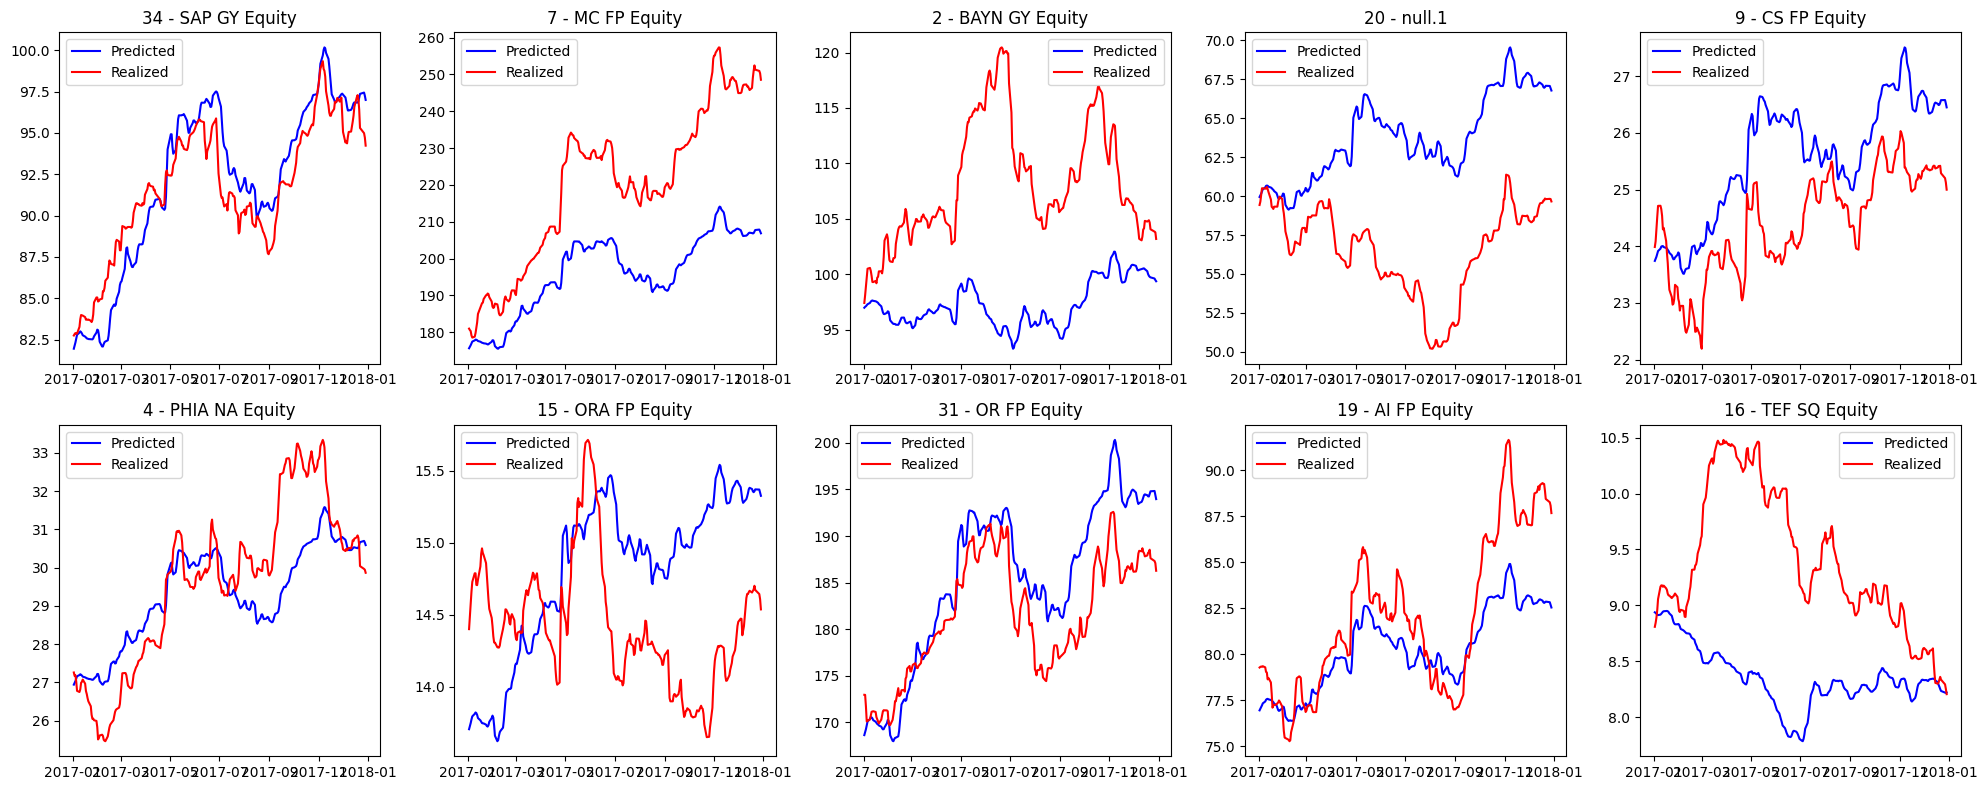

In [42]:
rand = np.random.choice(np.arange(41), size=10, replace=False)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, stock in enumerate(rand):
    row = i // 5
    col = i % 5
    axs[row, col].plot(yhat_inverse.iloc[:, stock], color='blue', label='Predicted')
    axs[row, col].plot(y_test_inverse.iloc[:, stock], color='red', label='Realized')
    axs[row, col].legend()
    axs[row, col].set_title(f'{stock} - {yhat_inverse.iloc[:, stock].name}')

plt.tight_layout()
plt.show()

### CNN-BiLSTM

----------------

### DO NOT CONSIDER CODE BELOW

In [43]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

NameError: name 'get_ranking' is not defined

In [ ]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [ ]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------